In [1]:
import numpy as np
import copy
import pickle

from scipy import ndimage
from BaselineRemoval import BaselineRemoval
import matplotlib.pyplot as plt
import os

In [2]:
# file_location = "../data/Raman_Mouse/corrected_4_wavenumbers/"
file_location = "../data/Green_excitation/corrected_4_wavenumbers/"

filenames = np.load(f"{file_location}FileNames.npy")
with open(f"{'/'.join(file_location.split('/')[:-2])}/Sample_labels.pickle", 'rb') as f:
    labels = pickle.load(f)

wavenumbers = np.load(f"{file_location}Wavenumbers.npy")
    
data = []
for f in filenames:
    x = np.load(f"{file_location}{f.split('.')[0]}.npy")
    data.append(((x.reshape(-1,x.shape[-1])).reshape(x.shape), labels[f]))

In [3]:
rng = np.random.default_rng()

class Kalman():    
    def __init__(self, X, grad, e, neighbourhood, photo_smoothness = 5000, noise_smoothness = 2, correct_photo_appr_blacknoise=True):
        self.X = X
        self.N_wavenumbers = self.X.shape[0]
        self.N_photo_appr = X.shape[1] - 1
        self.photo_smoothness = photo_smoothness
        self.noise_smoothness = noise_smoothness
        
        self.C = np.array([[1,1]] +
                           [[1,0]] * self.N_photo_appr)
        self.A = np.zeros((self.N_wavenumbers, 2, 2))
        self.A[:,0,0] = grad
        self.A[:,1,1] = 1
        
        if correct_photo_appr_blacknoise:
            self.e = np.array([e] * X.shape[1])
        else:
            self.e = np.array([e] + [0] * self.N_photo_appr)
            
        self.n = neighbourhood
        self.mu = np.empty((self.N_wavenumbers, 2))
        self.M = np.empty((self.N_wavenumbers, 2, 2))
        self.nu = np.empty((self.N_wavenumbers+1, 2))
        self.V = np.empty((self.N_wavenumbers+1, 2, 2))
        self.J = np.empty((self.N_wavenumbers, 2, 2))

        self.nu[0] = [X[0,0], 0]
        
        self.Sigma = np.diag(rng.standard_normal(1 + self.N_photo_appr))
        self.Gamma = np.diag(rng.standard_normal(2))
        self.V[0] = [[0, 0],
                     [0, 0]]
    
    @property
    def raw_data(self):
        return self.X, self.A[:,0,0]
    
    @raw_data.setter
    def raw_data(self, args):
        value, grad = args
        self.X = value
        self.nu[0] = [self.X[0,0], 0]
        self.A[:,0,0] = grad
        self.EM(1)
        
    def _filter_step(self, i):
        CV = self.C @ self.V[i]
        b = self.C @ self.nu[i] + self.e
        B = CV @ self.C.T + self.Sigma 
        K = self.V[i] @ self.C.T @ np.linalg.inv(B)
        self.mu[i] = self.nu[i] + K @ (self.X[i] - b)
        self.mu[i,0] = min(min(self.X[max(0,i-self.n):min(self.N_wavenumbers,i+self.n)+1,0]) - self.e[0], self.mu[i,0])
        self.mu[i,1] = max(0, self.mu[i,1])
        self.M[i] = self.V[i] - K @ CV

        # transition
        self.nu[i+1] = self.A[i] @ self.mu[i]
        self.V[i+1] = self.A[i] @ self.M[i] @ self.A[i] + self.Gamma # A = A.T
        
    def _smoother_step(self, i):
        self.J[i] = self.M[i-1] @ self.A[i] @ np.linalg.inv(self.V[i])
        self.M[i-1] += self.J[i] @ (self.M[i] - self.V[i]) @ self.J[i].T
        self.mu[i-1] += self.J[i] @ (self.mu[i] - self.nu[i])
        self.mu[i,0] = min(min(self.X[max(0,i-self.n):min(self.N_wavenumbers,i+self.n)+1,0]) - self.e[0], self.mu[i,0])
        self.mu[i,1] = max(0, self.mu[i,1])
    
    def kalman_filter(self):
        for i in range(len(self.X)):
            self._filter_step(i)
            
    def kalman_smoother(self):
        self.kalman_filter()
        
        for i in range(len(self.X)-1, 0, -1):
            self._smoother_step(i)
            
    def EM(self, n):
        lst = [copy.copy(self.A[:,0,0])]
        lst2 = []
        for i in range(n):
            self.kalman_smoother()
            E_z = self.mu
            E_zz = self.M + self.mu.reshape(-1,self.mu.shape[1],1) @ self.mu.reshape(-1,1,self.mu.shape[1])
            E_z_1z = (self.J @ self.M)[1:] + self.mu[:-1].reshape(-1,self.mu.shape[1],1) @ self.mu[1:].reshape(-1,1,self.mu.shape[1])

            # skip nu_0, V_0, A and C
            self.Gamma = np.sum(E_zz[1:] - 
                                E_z_1z.transpose(0,2,1) @ self.A[:-1].transpose(0,2,1) - 
                                self.A[:-1] @ E_z_1z + 
                                self.A[:-1] @ E_zz[:-1] @ self.A[:-1].transpose(0,2,1),
                                0) / self.N_wavenumbers
    
            self.Sigma = (self.X.T @ self.X - 
                         self.C @ E_z.T @ self.X - 
                         self.X.T @ E_z @ self.C.T + 
                         np.sum(self.C @ E_zz @ self.C.T, 0)) / (self.N_wavenumbers + 1)
            
            # make covarience diagonal
            self.Sigma = np.diag(np.diag(self.Sigma)) 
            self.Sigma[0,0] /= self.noise_smoothness
                        
            c = (self.Gamma[0,0] + self.Gamma[1,1]) / self.photo_smoothness
            self.Gamma = np.diag([c, c*(self.photo_smoothness-1)])
            
            
def split_signal(img):
    black_noise = 0

    x = img[0].reshape(-1, img[0].shape[-1])
    
    baseObj = BaselineRemoval(x[0])

    Modpoly_output = baseObj.ModPoly(4)
    Zhangfit_output = baseObj.ZhangFit()

    poly = x[0] - Modpoly_output
    grad = ndimage.gaussian_filter(np.pad(poly[1:] / poly[:-1],(0, 1), 'edge'), 50)

    poly2 = x[0] - Zhangfit_output
    grad2 = ndimage.gaussian_filter(np.pad(poly2[1:] / poly2[:-1],(0, 1), 'edge'), 50)
    grad = (grad + grad2)/2
    
    obj = Kalman(np.stack((x[0], poly, poly2)).T, grad, black_noise, 1, photo_smoothness=5000, noise_smoothness = 2)
    obj.EM(10)
    
    raman = np.empty(x.shape)
    photo = np.empty(x.shape)
    
    for pixel in range(x.shape[0]):
        baseObj = BaselineRemoval(x[pixel])

        Modpoly_output = baseObj.ModPoly(4)
        Zhangfit_output = baseObj.ZhangFit()

        poly = x[pixel] - Modpoly_output
        grad = ndimage.gaussian_filter(np.pad(poly[1:] / poly[:-1],(0, 1), 'edge'), 50)

        poly2 = x[pixel] - Zhangfit_output
        grad2 = ndimage.gaussian_filter(np.pad(poly2[1:] / poly2[:-1],(0, 1), 'edge'), 50)
        grad = (grad + grad2)/2
    
        obj.raw_data = np.stack((x[pixel], poly, poly2)).T, grad
        
        raman[pixel] = obj.mu[:,1]
        photo[pixel] = obj.mu[:,0]
        
    return raman, photo

In [4]:
import timeit
from os import path

file_location2 = f"{'/'.join(file_location.split('/')[:-2])}/approximated/"
os.makedirs(file_location2, exist_ok=True)

shape = data[0][0].shape

for j, (f, img) in enumerate(zip(filenames, data)):   
    start = timeit.default_timer()
    if path.exists(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman.npy'):
        print(f'file already exist {file_location2}{f.split("/")[-1].split(".")[0]}_raman')
        continue

    raman, photo = split_signal(img)

    stop = timeit.default_timer()
    print('Time: ', stop - start)  
    
    np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman', raman.reshape(shape))
    np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_photoluminescence', photo.reshape(shape))
    print(f"image: {f} is done.")
    

Time:  339.45666339999997
image: ML-MoS2-532-LP10-2-3-50X.npy is done.


In [6]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['figure.dpi'] = 500

In [15]:
img = img[0].reshape(-1,7500)

135


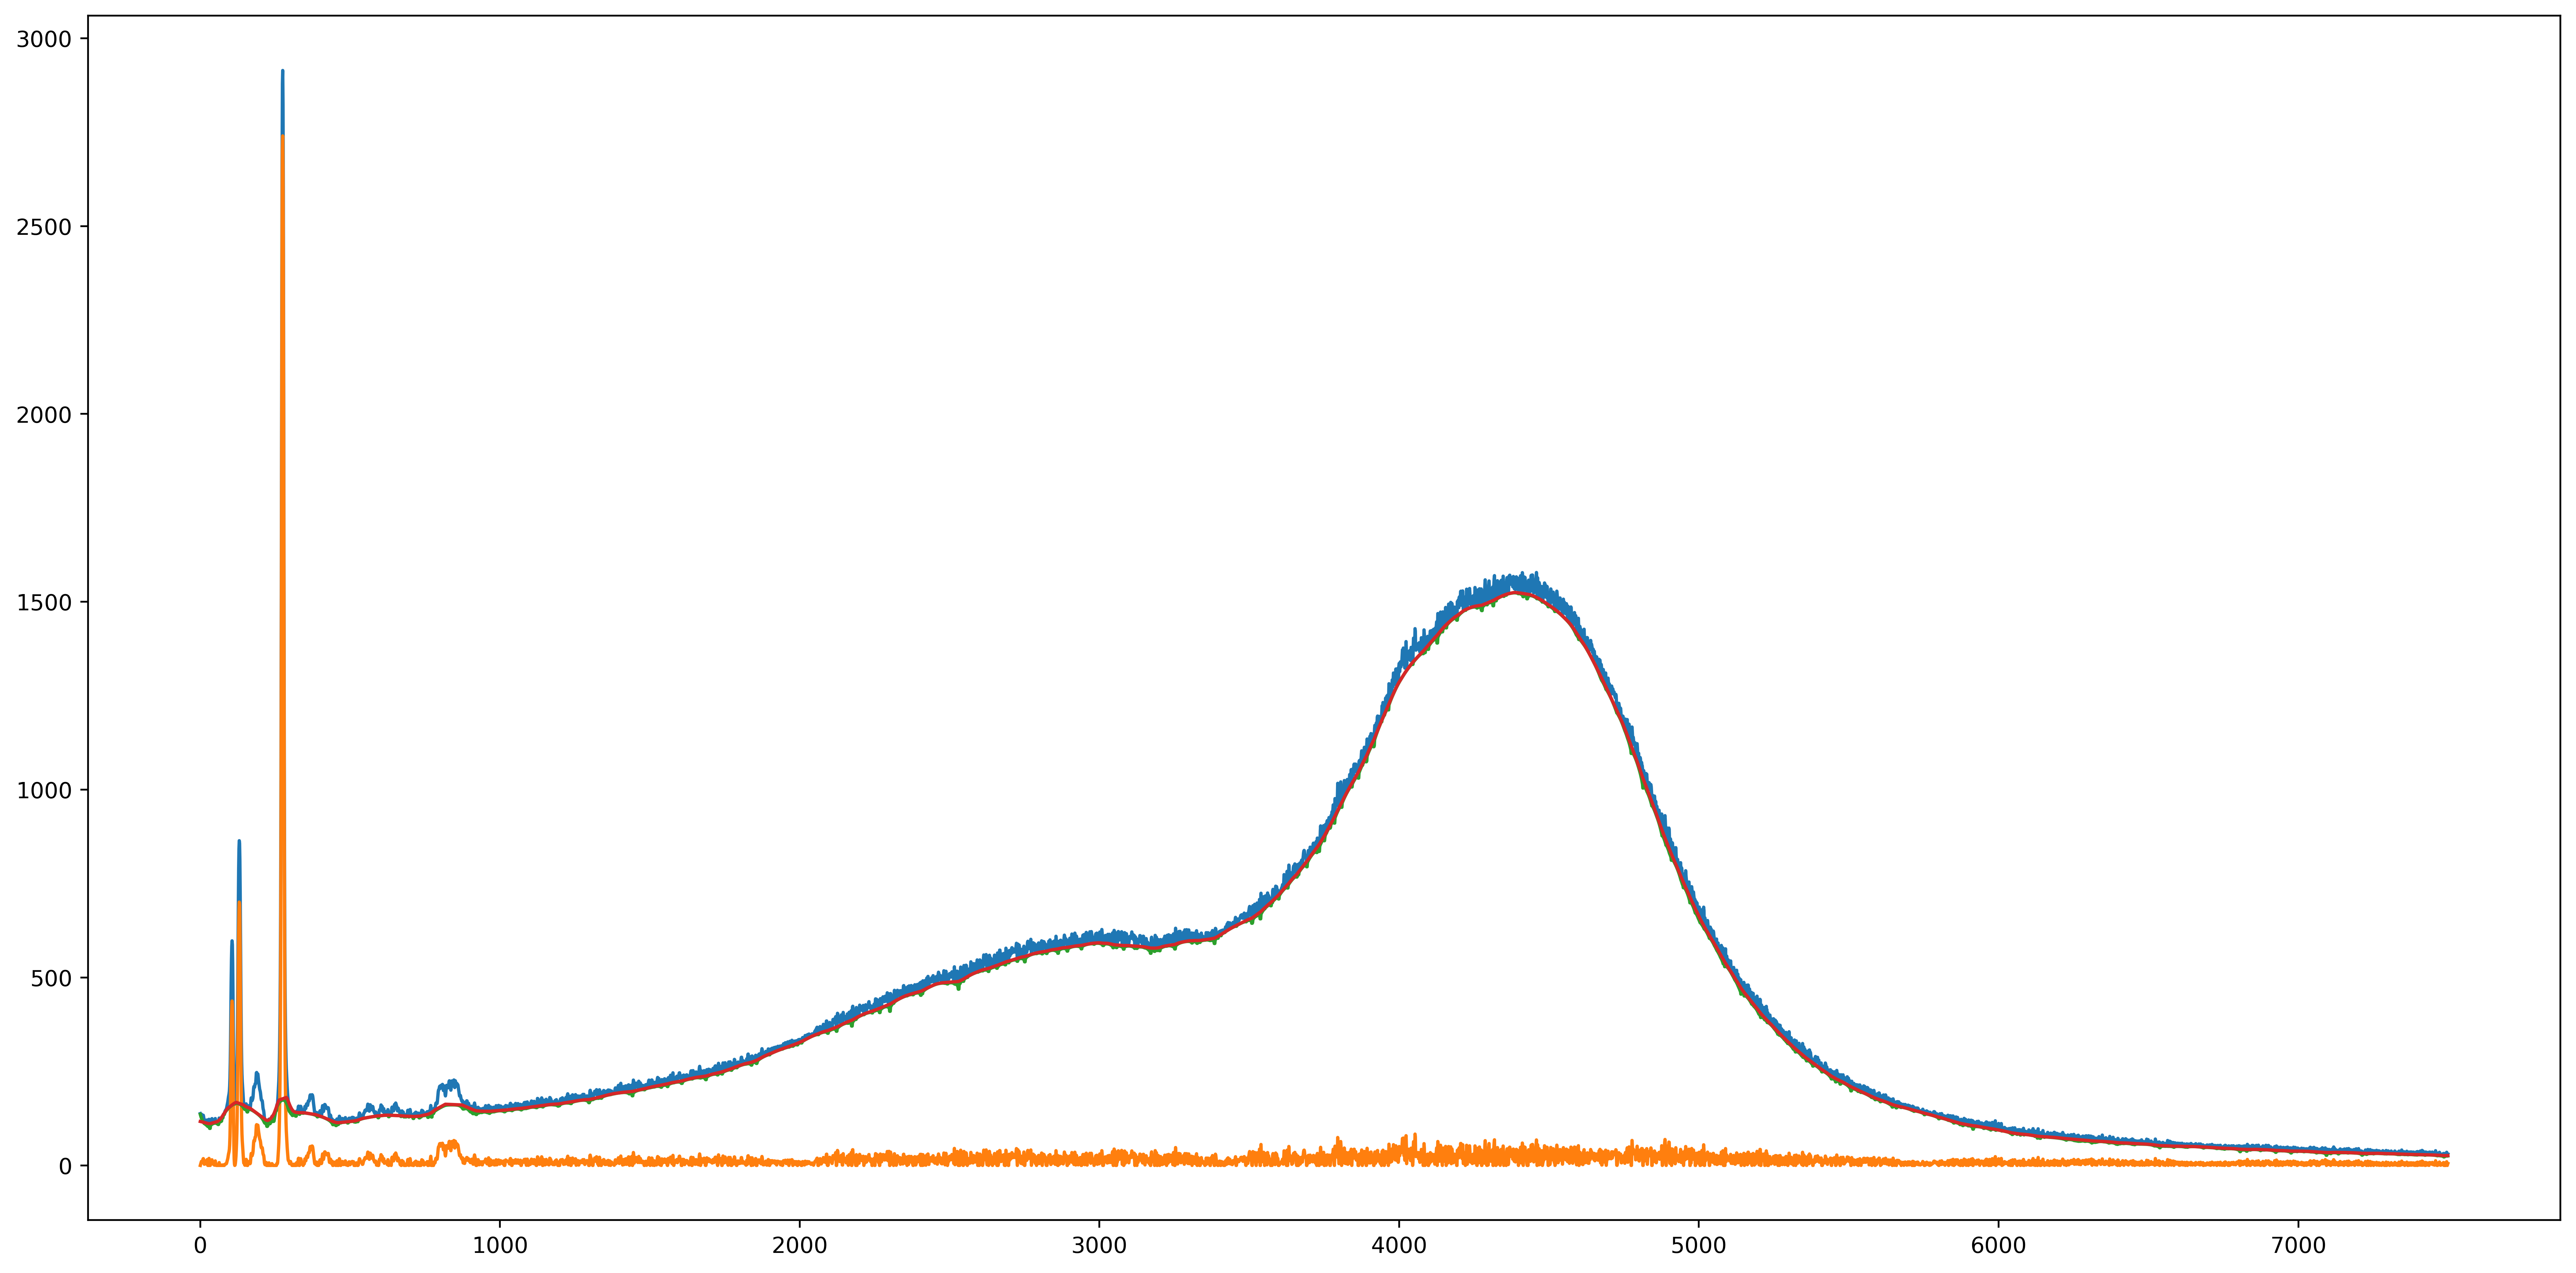

In [25]:
n= np.random.randint(384)
print(n)
plt.plot(img[n])
plt.plot(raman[n])
plt.plot(photo[n])
baseObj = BaselineRemoval(img[n])
Zhangfit_output = baseObj.ZhangFit()
plt.plot(img[n]-Zhangfit_output)
plt.show()